# Mount to Google Drivce

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/UNIST/2023_1/MobileComputing
!ls
!ls ./dataset

/content/drive/MyDrive/UNIST/2023_1/MobileComputing
archive.zip		 fresh_fruit_mobileNet1.h5  models   pickle
converted_model1.tflite  FreshFruitModel.ipynb	    models2  plot
dataset			 fruit_hero2.ipynb	    pb	     presentation
dataset  test  train


# Import modules

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.use("Agg")

import keras.utils
from keras import utils as np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from model.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# MobileNet is designed to work with images of dim 224, 224
img_rows, img_cols = 224, 224

model = MobileNet(weights='imagenet', input_shape=(img_rows, img_cols, 3), include_top=False)

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default

for layer in model.layers:
  layer.trainable = True

for (i, layer) in enumerate(model.layers):
  if layer.trainable:
    print(i, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f0a84817dc0>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0a35859e40>
2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0bc52633a0>
3 <keras.layers.activation.relu.ReLU object at 0x7f0a3585a0b0>
4 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f0a3585add0>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0a3585ba60>
6 <keras.layers.activation.relu.ReLU object at 0x7f0a3582e200>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0a3582ed40>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0a3582c250>
9 <keras.layers.activation.relu.ReLU object at 0x7f0a3582ca90>
10 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0a35d5e950>
11 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f0a35d5c9d0>
12 <keras.layers.normalization.batch_normalization.BatchNorm

In [ ]:
def addTopModelMobileNet(bottom_model, num_classes):
  """creates the top or head of the model that will be placed on top of the bottom layers"""

  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)

  return top_model

In [ ]:
num_classes = 7 # ['banana-fresh', 'banana-rotten', 'apple-fresh', 'apple-rotten', 'orange'fresh', orange-rotten', 'No fruit']

FC_HEAD = addTopModelMobileNet(model, num_classes)

model = Model(inputs = model.input, outputs = FC_HEAD)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

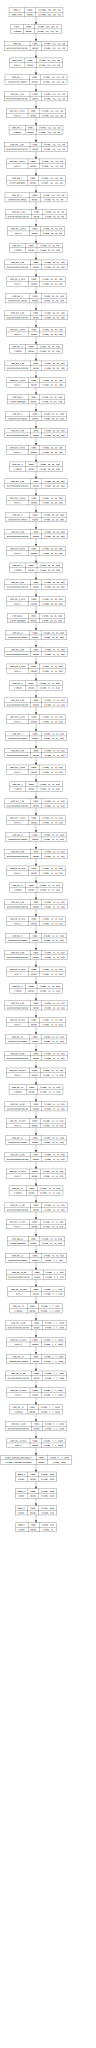

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Train model 1

### Old version

In [ ]:
train_data_dir = './dataset/train'
validation_data_dir = './dataset/test'

train_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_aug = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_aug.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator=validation_aug.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10888 images belonging to 6 classes.
Found 1255 images belonging to 6 classes.


In [ ]:
checkpoint = ModelCheckpoint(
    'fresh_fruit_mobileNet.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.2,
    min_lr=0.0001
)

callbacks = [earlystop, checkpoint, learning_rate_reduction]

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, decay=1e-3 / 40),
              metrics=['accuracy']
              )

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
num_train_samples = 10888
num_validation_samples = 1255

# train the network
print("[INFO] training network...")
H = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples//batch_size,
    epochs=40,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=num_validation_samples//batch_size
)

path_model_output = './models3'

# save the model to disk
print("[INFO] serializing network...")
model.save(path_model_output)

[INFO] training network...


<ipython-input-48-ffb0a93cc34f>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/40


InvalidArgumentError: ignored

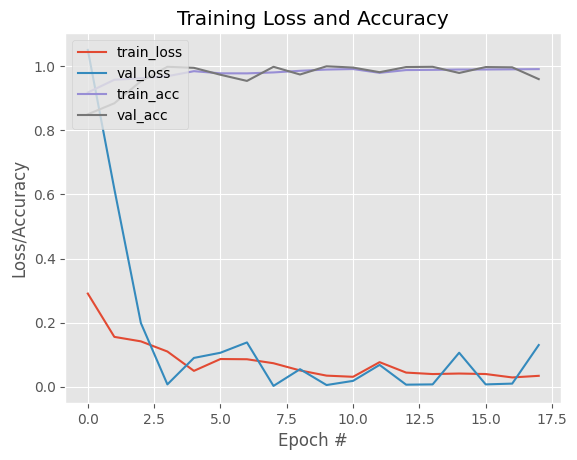

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 18
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("../lb4.png")

# Train model 2 RAM OverUse Problem occured

In [ ]:
path_data= './dataset/'
path_model_output='../models/lb4.model'
path_pickle= '../lb4.pickle'
path_plot= '../lb4.png'

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 40
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

# initialize the data and labels
data = []
labels = []

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(path_data)))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

[INFO] loading images...
[INFO] data matrix: 5539.54MB


In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [ ]:
# initialize the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']
              )

In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save(path_model_output)

# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(path_pickle, "wb")
f.write(pickle.dumps(lb))
f.close()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(path_plot)

# Test model

In [ ]:
# Load model
from tensorflow.keras.models import load_model

model_path = './fresh_fruit_mobileNet1.h5'
model = load_model(model_path)

In [ ]:
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import decode_predictions

test_history = model.evaluate(validation_generator)

40/40 [==============================] - 9s 207ms/step - loss: 0.0025 - accuracy: 0.9984


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(model,test_dataX, test_dataY, class_names,
                           figsize = (10,7), fontsize=14):

    prediction= model.predict(test_dataX)
    matrix = confusion_matrix(test_dataY.argmax(axis=1), prediction.argmax(axis=1))
    df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
test_data = []
test_labels = []
num_batches = len(validation_generator)

for i in range(num_batches):
    batch_data, batch_labels = validation_generator[i]
    test_data.append(batch_data)
    test_labels.append(batch_labels)

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix

predY= model.predict(test_data)
print(len(predY))
matrix = confusion_matrix(test_labels.argmax(axis=1), predY.argmax(axis=1))
print(matrix)

40/40 [==============================] - 2s 38ms/step
1255
[[395   0   0   0   0]
 [  0 381   0   0   0]
 [  0   0 373   0   1]
 [  0   0   0 104   1]
 [  0   0   0   0   0]]


In [ ]:
print(test_labels)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


40/40 [==============================] - 1s 29ms/step


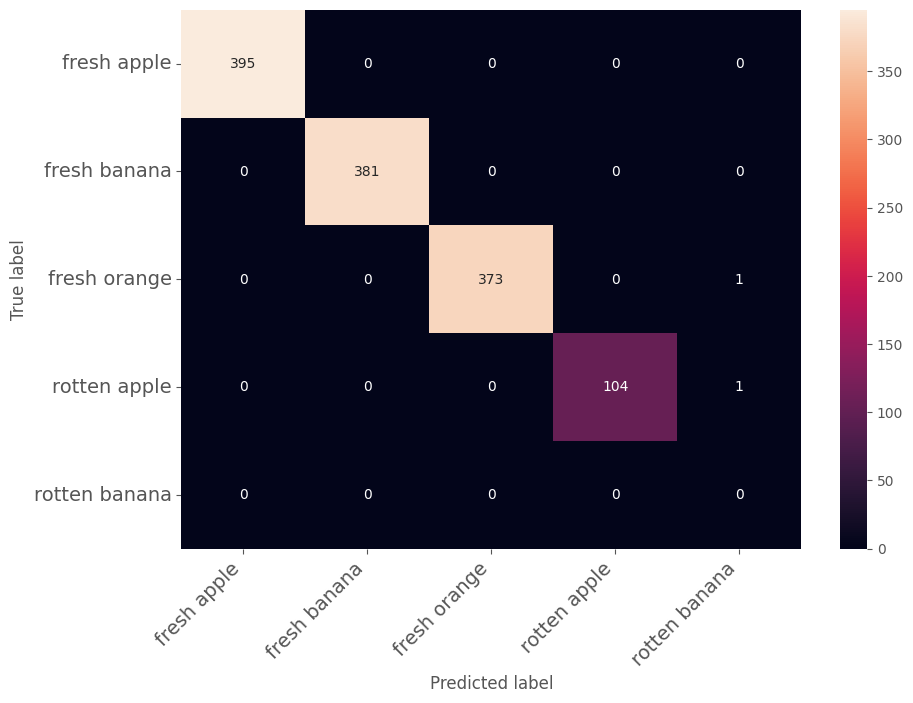

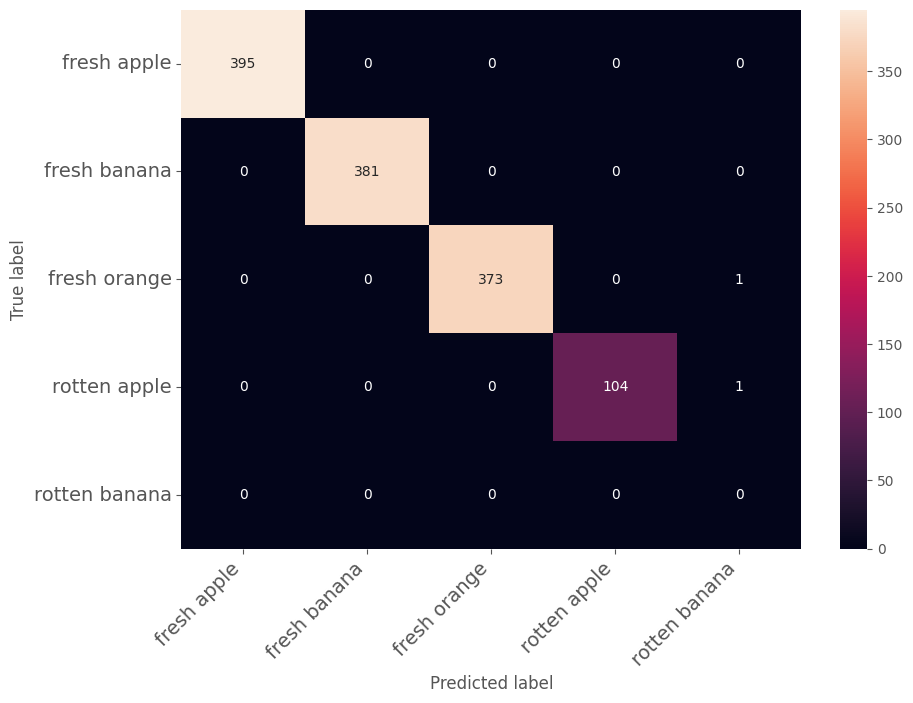

In [ ]:
print_confusion_matrix(model=model, test_dataX=test_data, test_dataY=test_labels, class_names=['fresh apple', 'fresh banana', 'fresh orange', 'rotten apple', 'rotten banana'])

# Extract model, i.e., convert to tensorflow light

In [ ]:
from tensorflow import keras
model = keras.models.load_model('./fresh_fruit_mobileNet.h5', compile=False)

export_path = './pb'
model.save(export_path, save_format="tf")

In [ ]:
import tensorflow as tf

saved_model_dir = export_path
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open('./converted_model.tflite', 'wb').write(tflite_model)

23309208